In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import torch
import argparse
import gc
import random

torch.manual_seed(0)
random.seed(0)
import numpy as np
np.random.seed(0)
from tqdm import tqdm, trange
import torch
from PIL import Image
from numpy import trapz
from torchvision.transforms import PILToTensor
from torchvision import transforms
import torch.nn as nn 
from torch.nn import functional as F
import numpy as np
import torch
import matplotlib.pyplot as plt

from llava.mm_utils import tokenizer_image_token, process_images, get_model_name_from_path
import copy
from llava.model.builder import load_pretrained_model


/home/zhuyao123/miniconda3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-02-17 17:27:15,658] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.1
 [WARNING]  using untested triton version (2.1.0), only 1.0.0 is known to be compatible


In [ ]:
####################################################
######### Load your model ##########
####################################################

model_path = os.path.expanduser("xxxxxxxxxx/llava-v1.5-7b")
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, None, model_name)

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/home/zhuyao123/miniconda3/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


In [3]:
####################################################
######### Generate the patches ##########
####################################################

feature_size = 12
patch_size = 28  
masks_list = []
for i in range(feature_size*feature_size):
    masks_list.append(torch.zeros([feature_size*patch_size,feature_size*patch_size]).unsqueeze(0))
masks_list = torch.cat(masks_list, dim=0)
# print(masks_list.shape)
for i in range(feature_size):
    for j in range(feature_size):
        low1 = i*patch_size
        low2 = j*patch_size
        high1 = (i+1)*patch_size
        high2 = (j+1)*patch_size
        for m in range(low1,high1):
            for n in range(low2,high2):
                masks_list[i*feature_size+j][m][n]=1
masks_list = masks_list.bool()
masks_list = np.array(masks_list.cpu().detach())

In [ ]:
####################################################
######### Load the test image ##########
####################################################

image_name = "./Human_Dataset/images/COCO_val2014_000000288576.jpg"

# Example1
image_Image = Image.open(image_name).convert("RGB")
images = process_images([image_Image], image_processor, model.config).cpu()
images = images.to(dtype=torch.float16, device='cuda', non_blocking=True)

# Example2
# default_question_template = "What sport is he playing? (One word answer, please.)"
# default_answer_template = "{}"
# text = "Frisbee"

# Example3
# default_question_template = "What is the color of the Frisbee? (One word answer, please.)"
# default_answer_template = "{}"
# text = "Red"

default_question_template = "Does this image show a 'Frisbee'? (One word answer, please.)"
default_answer_template = "{}"
text = "Yes"

torch.cuda.empty_cache()

images_np = np.transpose((images.squeeze(0)).detach().cpu().numpy(), (1, 2, 0))

input_image_copy = images_np.copy()
patch_masks = masks_list


In [5]:
######################################################################
######### Patchwise Cooperative Game-based Interpretability ##########
######################################################################

from shap.Cooperative import *
auc_mask, shap_list = Cooperative(input_image_copy,text,patch_masks,model,tokenizer,default_question_template,default_answer_template,lr=0.015,simu_num=350,version=0,batch=60)

loss: 13.371999397873878


torch.Size([1, 3, 336, 336])


(-0.5, 335.5, 335.5, -0.5)

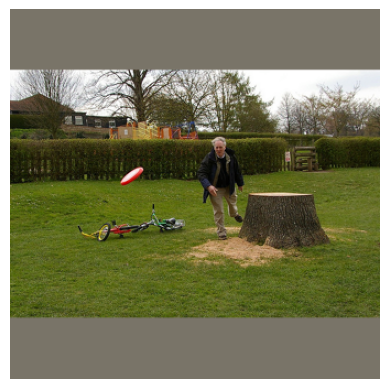

In [6]:
####################################################
######### Visualization of the test image ##########
####################################################

from torchvision import transforms
import matplotlib.pyplot as plt
channel_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
channel_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])

MEAN = [-mean/std for mean, std in zip(channel_mean, channel_std)]
STD = [1/std for std in channel_std]
normalizer = transforms.Normalize(mean=channel_mean, std=channel_std)
denormalizer = transforms.Normalize(mean=MEAN, std=STD)

def save_images(images, output_dir,filename):
    cur_images = (images[:, :, :] * 255).astype(np.uint8)
    im = Image.fromarray(cur_images)
    im.save('{}.png'.format(os.path.join(output_dir, filename)))
    
unloader = transforms.ToPILImage()

print(images.shape)

images_np = np.transpose((denormalizer(images[0])).detach().cpu().numpy(), (1, 2, 0)).astype(np.float32)

# print(images_np.dtype)

plt.figure()
plt.imshow(images_np)
plt.axis('off')

[113  88  82  80  40  83 141  85  46  56  77   1  89 107 100  90 102  32
 115 103  93  70  58  20   8  54  21  76  48 129  25  12 105 114  36   2
 118  39  73 111  16  24  78 112  91  33  86  68 121  84 108  50  69  45
 143 132  97  61 120  11 138  71 140  13  14  41  22 117  94 104 106 119
 109 110 116  81  99 126   3  72  52  59  49  98  37   9   7 122  43 131
 127  79  87  29  28  51  31  17  15  38  95  18  66 135 137 133 125  65
  75 134 123  42 101  60 142  67  74  96  35  44  19  53   6  34   5  47
  57  55   4   0 124 139  10 136  27  92  23 130  30 128  26  62  63  64]


(-0.5, 335.5, 335.5, -0.5)

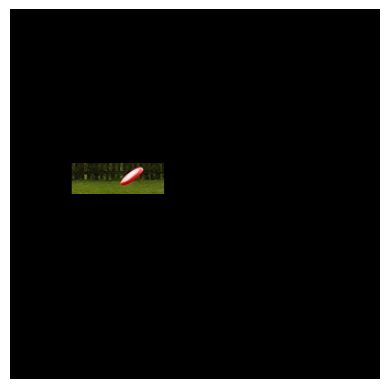

In [7]:
#################################################################
######### Visualization of the top-3 important patches ##########
#################################################################

print(np.argsort(shap_list))
final_explain = images_np*auc_mask[2]


plt.figure()
plt.imshow(final_explain)
plt.axis('off')

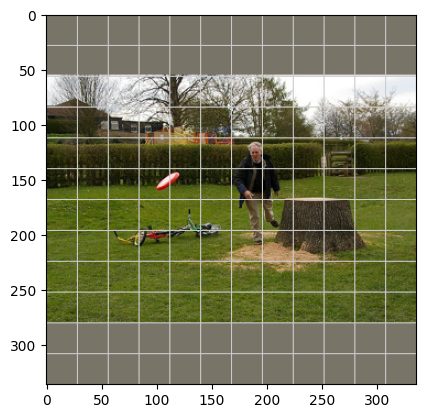

In [8]:


from PIL import Image, ImageDraw

from torchvision import transforms
import matplotlib.pyplot as plt

image_Image=Image.fromarray(np.uint8(images_np*255), mode='RGB')
width, height = image_Image.size

cell_width = width // 12
cell_height = height // 12

draw = ImageDraw.Draw(image_Image)
color_scale = 0.8 

for i in range(1, 12):
    y = i * cell_height
    draw.line((0, y, width, y), fill=((int)(255*color_scale),(int)(255*color_scale),(int)(255*color_scale)), width=1)

for j in range(1, 12):
    x = j * cell_width
    draw.line((x, 0, x, height), fill=((int)(255*color_scale),(int)(255*color_scale),(int)(255*color_scale)), width=1)
plt.imshow(image_Image)
plt.show()

torch.Size([1, 1, 12, 12])


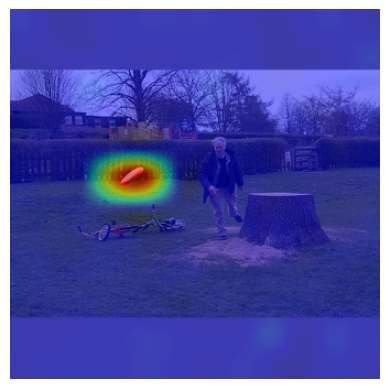

In [9]:
#################################################################
######### Visualization of the heatmap ##########################
#################################################################
shap_attention = shap_list.reshape(1,1,12,12)
shap_attention = torch.tensor(shap_attention)
# shap_attention = (shap_attention - shap_attention.min())/(shap_attention.max() - shap_attention.min())
shap_attention = (shap_attention - shap_attention.mean())/shap_attention.std()
shap_attention = torch.exp2(shap_attention/1.25)

import torch.nn.functional as F
print(shap_attention.shape)
shap_attention = F.interpolate(shap_attention, size=((336,336)), mode='bicubic').squeeze(0).squeeze(0)


plt.figure()
plt.imshow(images_np) ; plt.axis('off')
plt.imshow(255 * shap_attention.numpy(), alpha=0.5, cmap='jet')
plt.show()

In [10]:
#######################################################################
######### The Evaluation of the Faithfulness ##########################
#######################################################################

(-0.5, 335.5, 335.5, -0.5)

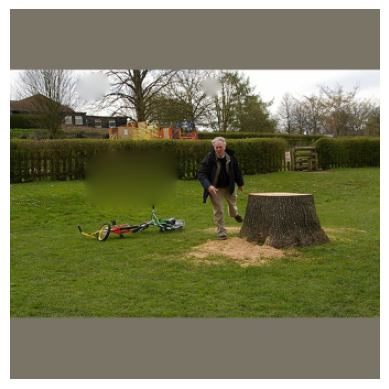

In [11]:
######################################################################################################
######### The Visualization of image after removing 5% most important parts ##########################
######################################################################################################
    

shap_masks = shap_attention.numpy()
perc = np.percentile(shap_masks, 95)
mask = np.where(shap_masks > perc, 0, 1)

masks = np.float32(mask==True)

imputer=NoisyLinearImputer(noise=0.0,weighting=neighbors_weights)
outimg = imputer(images[0].cpu().to(dtype=torch.float32), masks).squeeze(0)

plt.figure()
plt.imshow(unloader(denormalizer(outimg)))
plt.axis('off')

(-0.5, 335.5, 335.5, -0.5)

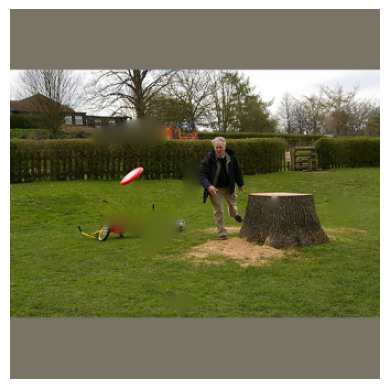

In [12]:
######################################################################################################
######### The Visualization of image after removing 5% least important parts ##########################
######################################################################################################
    

shap_masks = shap_attention.numpy()
perc = np.percentile(shap_masks, 5)
mask = np.where(shap_masks < perc, 0, 1)

masks = np.float32(mask==True)

imputer=NoisyLinearImputer(noise=0.0,weighting=neighbors_weights)
outimg = imputer(images[0].cpu().to(dtype=torch.float32), masks).squeeze(0)

plt.figure()
plt.imshow(unloader(denormalizer(outimg)))
plt.axis('off')

In [13]:
##############################################################################
####### Observe the change of model output confidence with line chart ########
##############################################################################

ours_most_list = []
for i_p in range(51):
    percentile = 100 - i_p*2

    perc = np.percentile(shap_masks, percentile)
    # masks = np.float32(shap_masks<perc)
    mask = np.where(shap_masks > perc, 0, 1)
    # print(images.shape,np.percentile(masks, 50))
    # mask = auc_mask[10].squeeze(2)
    masks = np.float32(mask==True)
    imputer=NoisyLinearImputer(noise=0.0,weighting=neighbors_weights)
    outimg = imputer(images[0].cpu().to(dtype=torch.float32), masks).squeeze(0)

    score = eval_model(tokenizer, model, outimg.unsqueeze(0).to(dtype=torch.float16), [text], question_template=default_question_template, answer_template=default_answer_template)
    ours_most_list.append(score)

ours_least_list = []
for i_p in range(51):
    percentile = 100 - i_p*2
    perc = np.percentile(shap_masks, percentile)
    # masks = np.float32(shap_masks<perc)
    mask = np.where(shap_masks < perc, 0, 1)
    # print(images.shape,np.percentile(masks, 50))
    # mask = auc_mask[10].squeeze(2)
    masks = np.float32(mask==True)
    imputer=NoisyLinearImputer(noise=0.0,weighting=neighbors_weights)
    outimg = imputer(images[0].cpu().to(dtype=torch.float32), masks).squeeze(0)

    score = eval_model(tokenizer, model, outimg.unsqueeze(0).to(dtype=torch.float16), [text], question_template=default_question_template, answer_template=default_answer_template)

    ours_least_list.append(score)

In [14]:
ours_most_list2 = [i - ours_most_list[0] for i in ours_most_list]
ours_least_list2 = [i - ours_least_list[-1] for i in ours_least_list]

[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0] [tensor(0.), tensor(-0.4961), tensor(-0.4727), tensor(-0.4961), tensor(-0.4961), tensor(-0.4961), tensor(-0.4961), tensor(-0.4961), tensor(-0.4961), tensor(-0.4961), tensor(-0.5156), tensor(-0.5156), tensor(-0.5156), tensor(-0.5566), tensor(-0.5938), tensor(-0.5156), tensor(-0.6113), tensor(-0.6309), tensor(-0.6465), tensor(-0.6602), tensor(-0.6602), tensor(-0.6602), tensor(-0.6768), tensor(-0.6768), tensor(-0.6914), tensor(-0.6768), tensor(-0.6768), tensor(-0.6602), tensor(-0.6914), tensor(-0.6602), tensor(-0.6602), tensor(-0.6602), tensor(-0.6602), tensor(-0.6309), tensor(-0.6465), tensor(-0.6309), tensor(-0.6602), tensor(-0.6465), tensor(-0.6768), tensor(-0.6602), tensor(-0.6465), tensor(-0.6

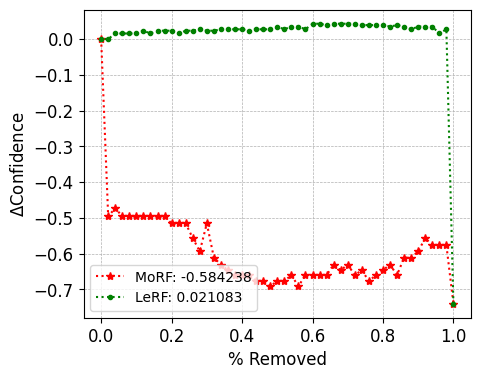

In [15]:
import matplotlib
import numpy as np
from  matplotlib import pyplot as plt

plt.figure(figsize=(5,4))

x = [(i)/50 for i in range(51)]
y = [i.cpu().detach()[0] for i in ours_most_list2]

x2 = [1-(i)/50 for i in range(51)]
y2 = [i.cpu().detach()[0] for i in ours_least_list2]

plt.plot(x, y,'*:r', label = 'MoRF: -0.584238')
plt.plot(x2, y2,'o:g',markersize=3, label = 'LeRF: 0.021083')
plt.grid(linestyle = '--', linewidth = 0.5)

print(x,y)
print("MoRF:",trapz(y, x, dx=0.001))
print("LeRF:",trapz(y2, x, dx=0.001))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('% Removed',fontsize=12)
plt.ylabel('$\Delta$Confidence',fontsize=12)
plt.legend(fontsize=10,loc="lower left")
plt.show()

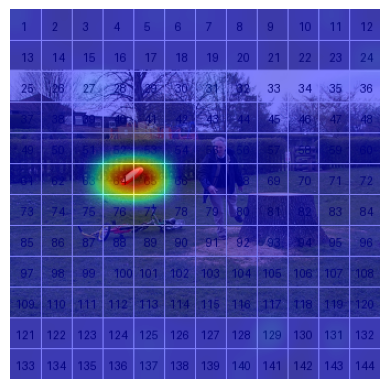

In [16]:
####################################################################
####Comparing model interpretation with human interpretation########
####Firstly, it is observed that the model thinks that the patch of the 64th and 65th image is the most important for decision-making.
####Then check the human annotation results in Human_Annotations.txt and Get:
# Image_Path                    Obj_Name  ID    First Second Third
# COCO_val2014_000000288576.jpg frisbee  2399 ;   64    65     0
####Human beings think that the 64th and 65th blocks in Coco_Val2014_00000288576.JPG have great influence on the decision-making of Frisbee.
####The results indicate that the model's decision-making relies on parts of the image that are similar to those used by humans.
####################################################################

plt.figure()
image_Image=Image.fromarray(np.uint8(images_np*255), mode='RGB')
width, height = image_Image.size
cell_width = width // 12
cell_height = height // 12
draw = ImageDraw.Draw(image_Image)
color_scale = 1 
for i in range(1, 12):
    y = i * cell_height
    draw.line((0, y, width, y), fill=((int)(255*color_scale),(int)(255*color_scale),(int)(255*color_scale)), width=1)
for j in range(1, 12):
    x = j * cell_width
    draw.line((x, 0, x, height), fill=((int)(255*color_scale),(int)(255*color_scale),(int)(255*color_scale)), width=1)
    
for i in range(12):
    for j in range(12):
        a = str((j)*12+i+1)
        if (j)*12+i<100:
            draw.text( (10+i*28,10+j*28), a,(0,0,0))
        else:
            draw.text( (5+i*28,10+j*28), a,(0,0,0))
# plt.imshow(image_Image*auc_mask[2])
plt.imshow(image_Image)
plt.imshow(255 * shap_attention.numpy(), alpha=0.5, cmap='jet')

plt.axis('off')
plt.show()